# Validation using various techniques

- K fold cross validation

It consists of splitting the available data into K partitions (typically = 4 or 5), instantiating K
identical models, and training each one on (K – 1) partitions while evaluating on the remaining partition.
The validation score for the model used is then the average of the K validation scores obtained.

<img src="../images/Screenshot 2021-12-16 123443.jpg">

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold

from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.utils import plot_model

### create model

In [12]:
def create_model(shape):
    # layers of the neural net
    input_layer = Dense(units=8, kernel_regularizer=l2(l2=0.01), activation=relu, input_shape=shape)
    drop_1 = Dropout(0.2)
    hidden_1 = Dense(units=8, kernel_regularizer=l2(l2=0.01), activation=relu)
    drop_2 = Dropout(0.2)
    output_layer = Dense(units=1)

    # compilation
    model = Sequential([input_layer, hidden_1, output_layer])
    model.compile(optimizer=RMSprop(learning_rate=0.01),
                  loss=mean_squared_error,
                  metrics=[mean_absolute_error])

    return model

### training

In [4]:
(X, Y), (test_x, test_y) = boston_housing.load_data(path='../data')
X.shape, Y.shape, test_x.shape, test_y.shape

((404, 13), (404,), (102, 13), (102,))

In [13]:
create_model(shape=(13,)).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 112       
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [6]:
plot_model(create_model(shape=(13,)))

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### normalize data

In [10]:
x_mean = X.mean(axis=0)
x_std = X.std(axis=0)

X -= x_mean
X /= x_std
test_x -= x_mean
test_x /= x_std

### cross validation

In [14]:
scores = []
histories = []
cv = KFold(n_splits=4, shuffle=True, random_state=64)

for fold, (train_id, val_id) in enumerate(cv.split(X, Y)):
    train_x, val_x = X[train_id], X[val_id]
    train_y, val_y = Y[train_id], Y[val_id]

    network = create_model(shape=(train_x.shape[1],))
    history = network.fit(train_x, train_y,
                          epochs=20,
                          batch_size=1,
                          validation_data=(val_x, val_y))

    predicted_y = network.predict(val_x)
    scores.append(mean_absolute_error(val_y, predicted_y))
    histories.append(history)

Epoch 1/20
303/303 [==============================] - 2s 4ms/step - loss: 143.1268 - mean_absolute_error: 8.0115 - val_loss: 54.1262 - val_mean_absolute_error: 4.6615
Epoch 2/20
303/303 [==============================] - 1s 4ms/step - loss: 24.0412 - mean_absolute_error: 3.2968 - val_loss: 31.6166 - val_mean_absolute_error: 3.2894
Epoch 3/20
303/303 [==============================] - 1s 4ms/step - loss: 17.7819 - mean_absolute_error: 2.7952 - val_loss: 28.4341 - val_mean_absolute_error: 2.8776
Epoch 4/20
303/303 [==============================] - 1s 4ms/step - loss: 15.3820 - mean_absolute_error: 2.6729 - val_loss: 27.4406 - val_mean_absolute_error: 3.1191
Epoch 5/20
303/303 [==============================] - 1s 4ms/step - loss: 13.9695 - mean_absolute_error: 2.6098 - val_loss: 32.7052 - val_mean_absolute_error: 3.8237
Epoch 6/20
303/303 [==============================] - 1s 4ms/step - loss: 13.7320 - mean_absolute_error: 2.5008 - val_loss: 21.0682 - val_mean_absolute_error: 2.7923
Epo

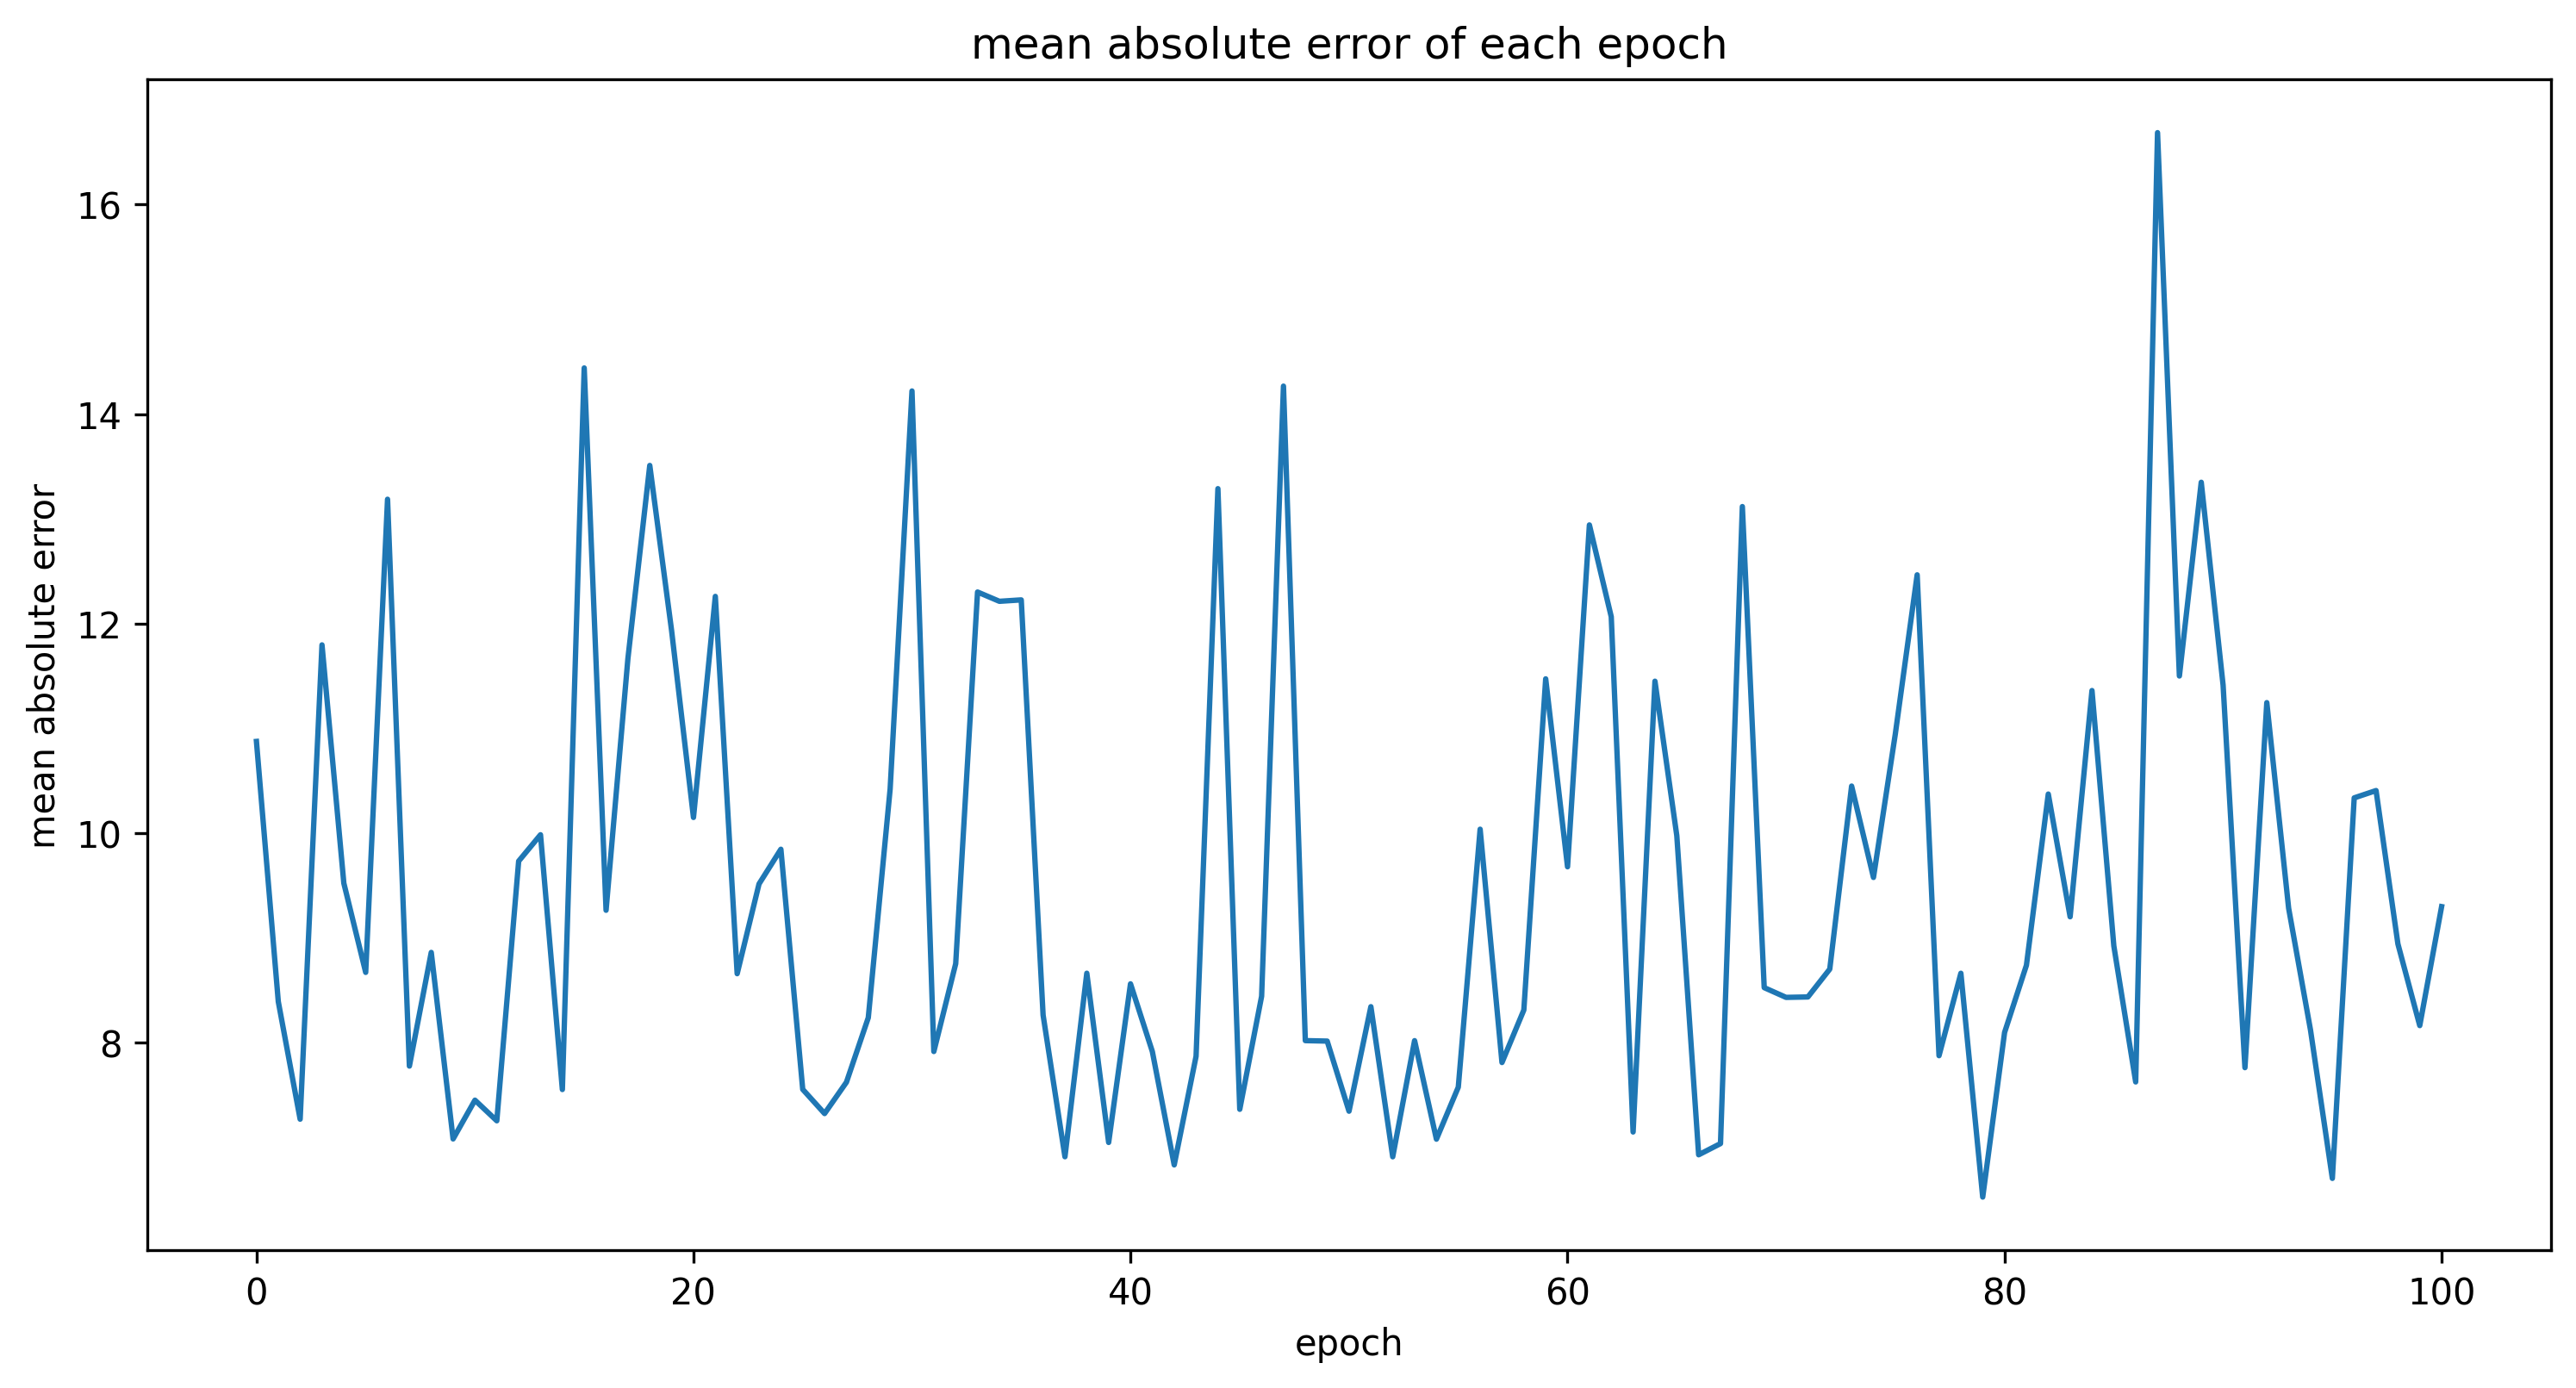

In [15]:
plt.figure(figsize=[12, 6], dpi=300)
sns.lineplot(x=list(range(101)), y=list(np.mean(scores, axis=0)))
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.title('mean absolute error of each epoch')
plt.show()

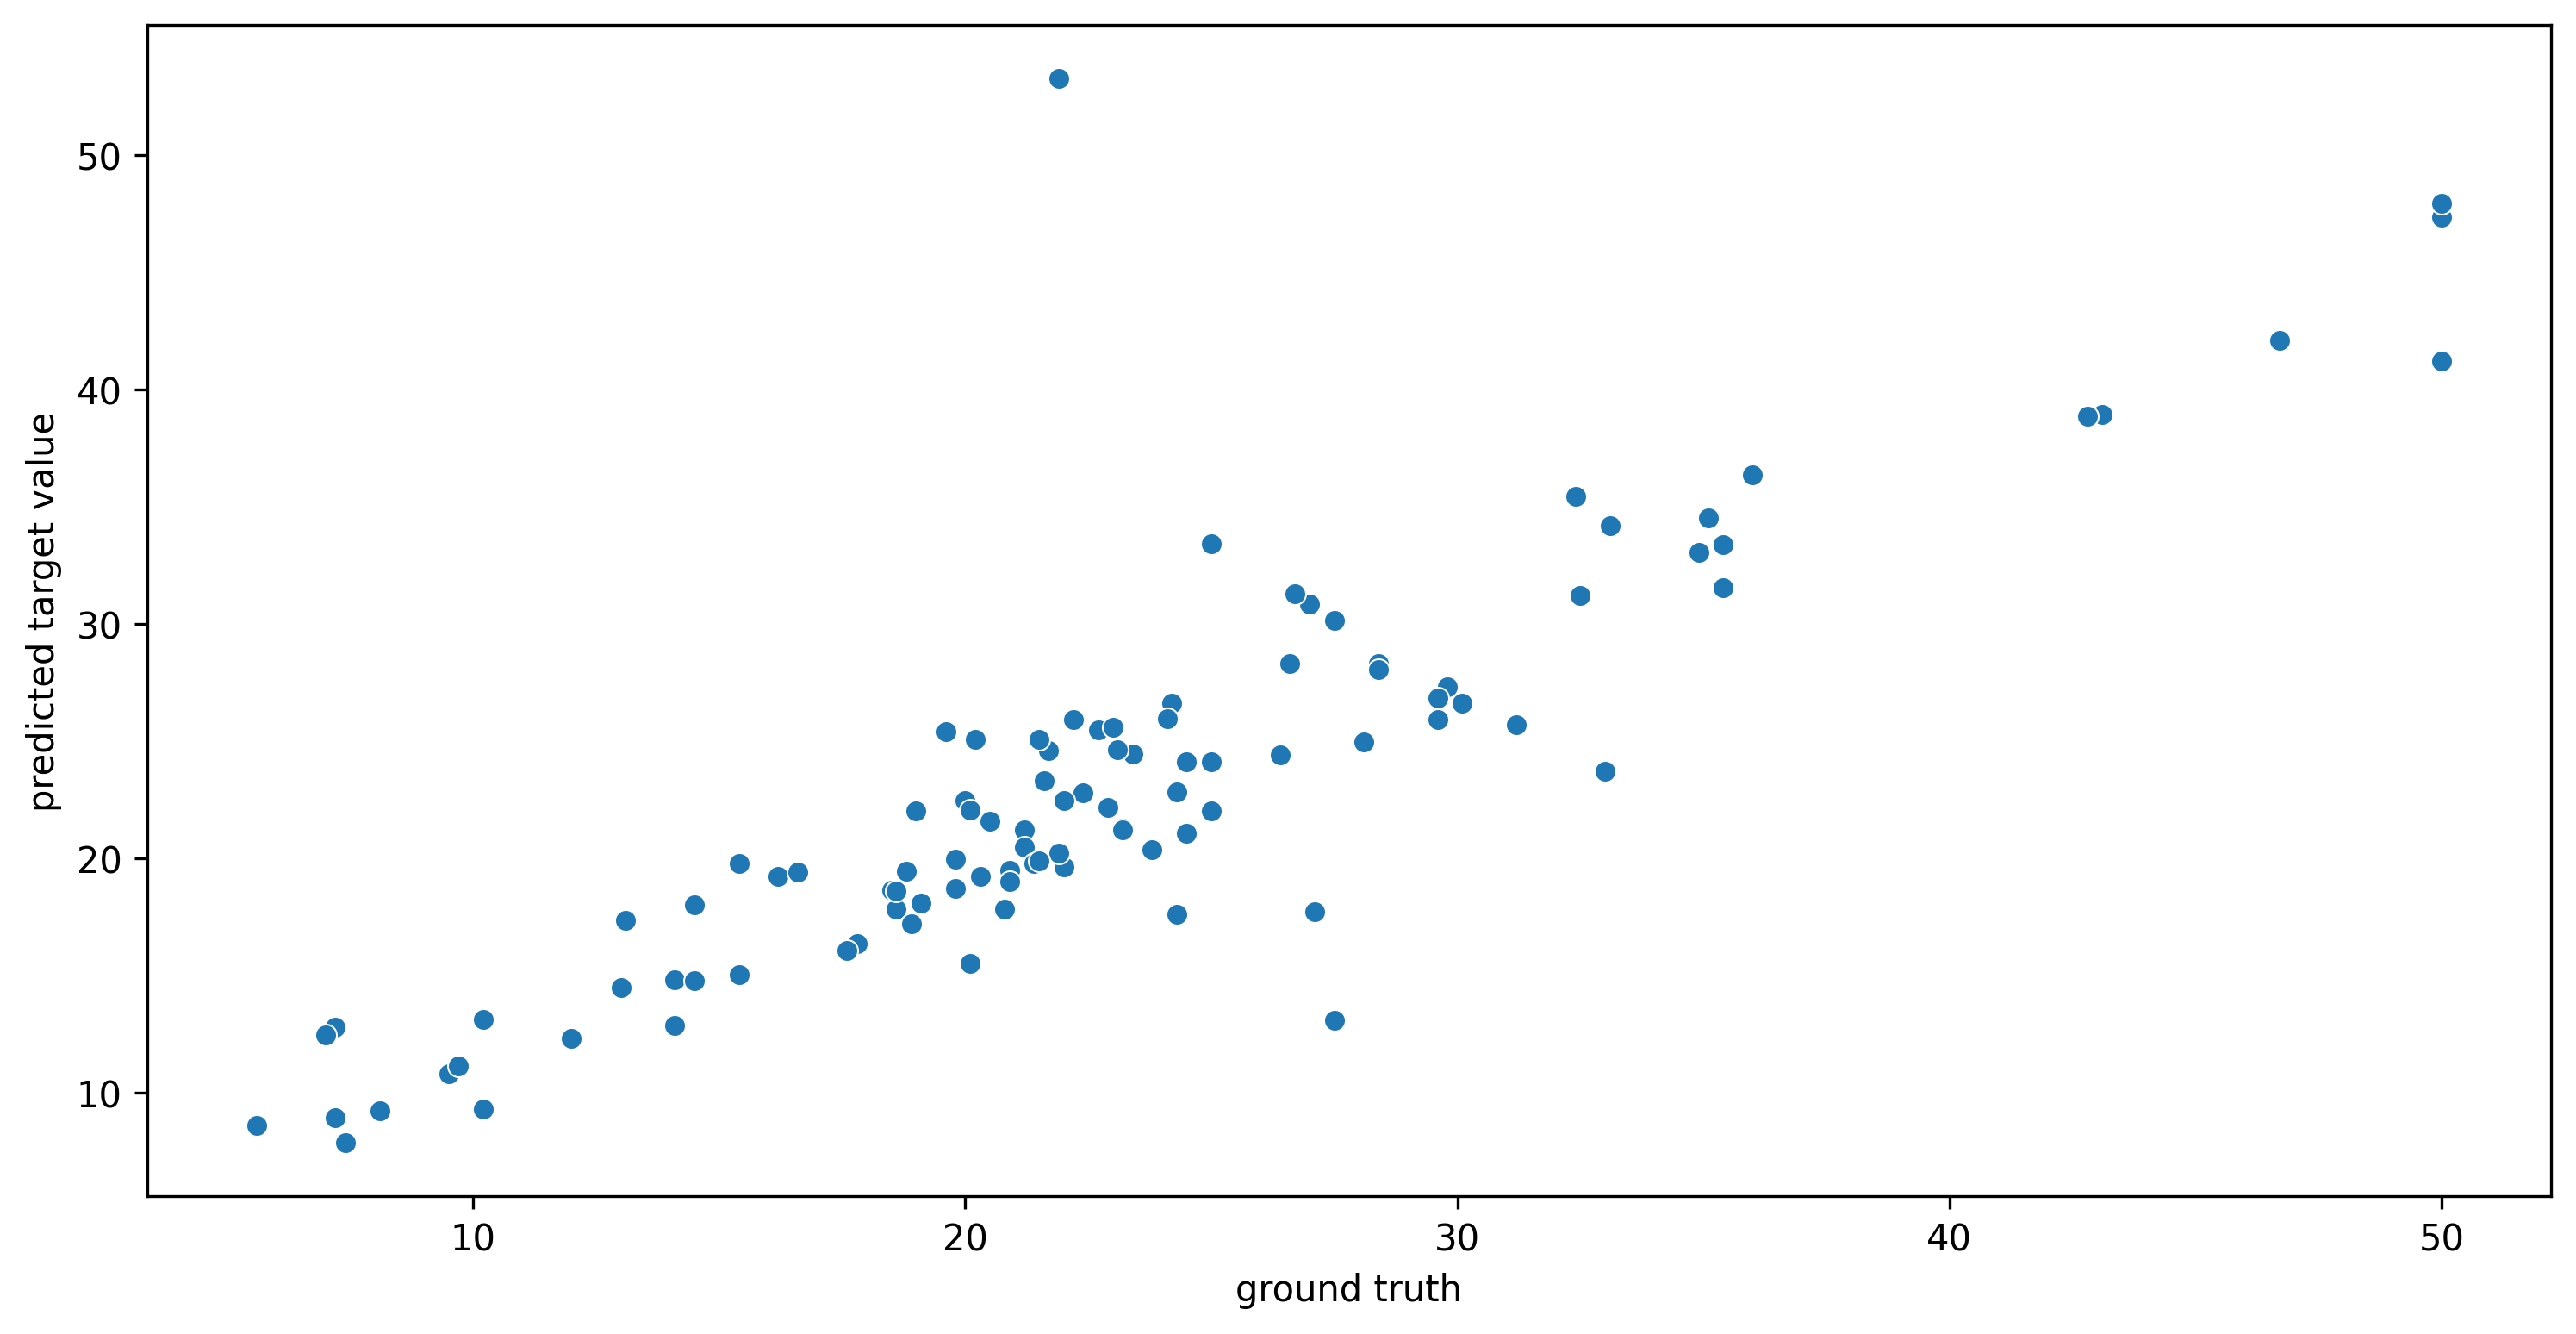

In [16]:
plt.figure(figsize=[12, 6], dpi=300)
sns.scatterplot(x=test_y, y=list(network.predict(test_x).reshape(1, -1))[0])
plt.xlabel('ground truth')
plt.ylabel('predicted target value')
plt.show()

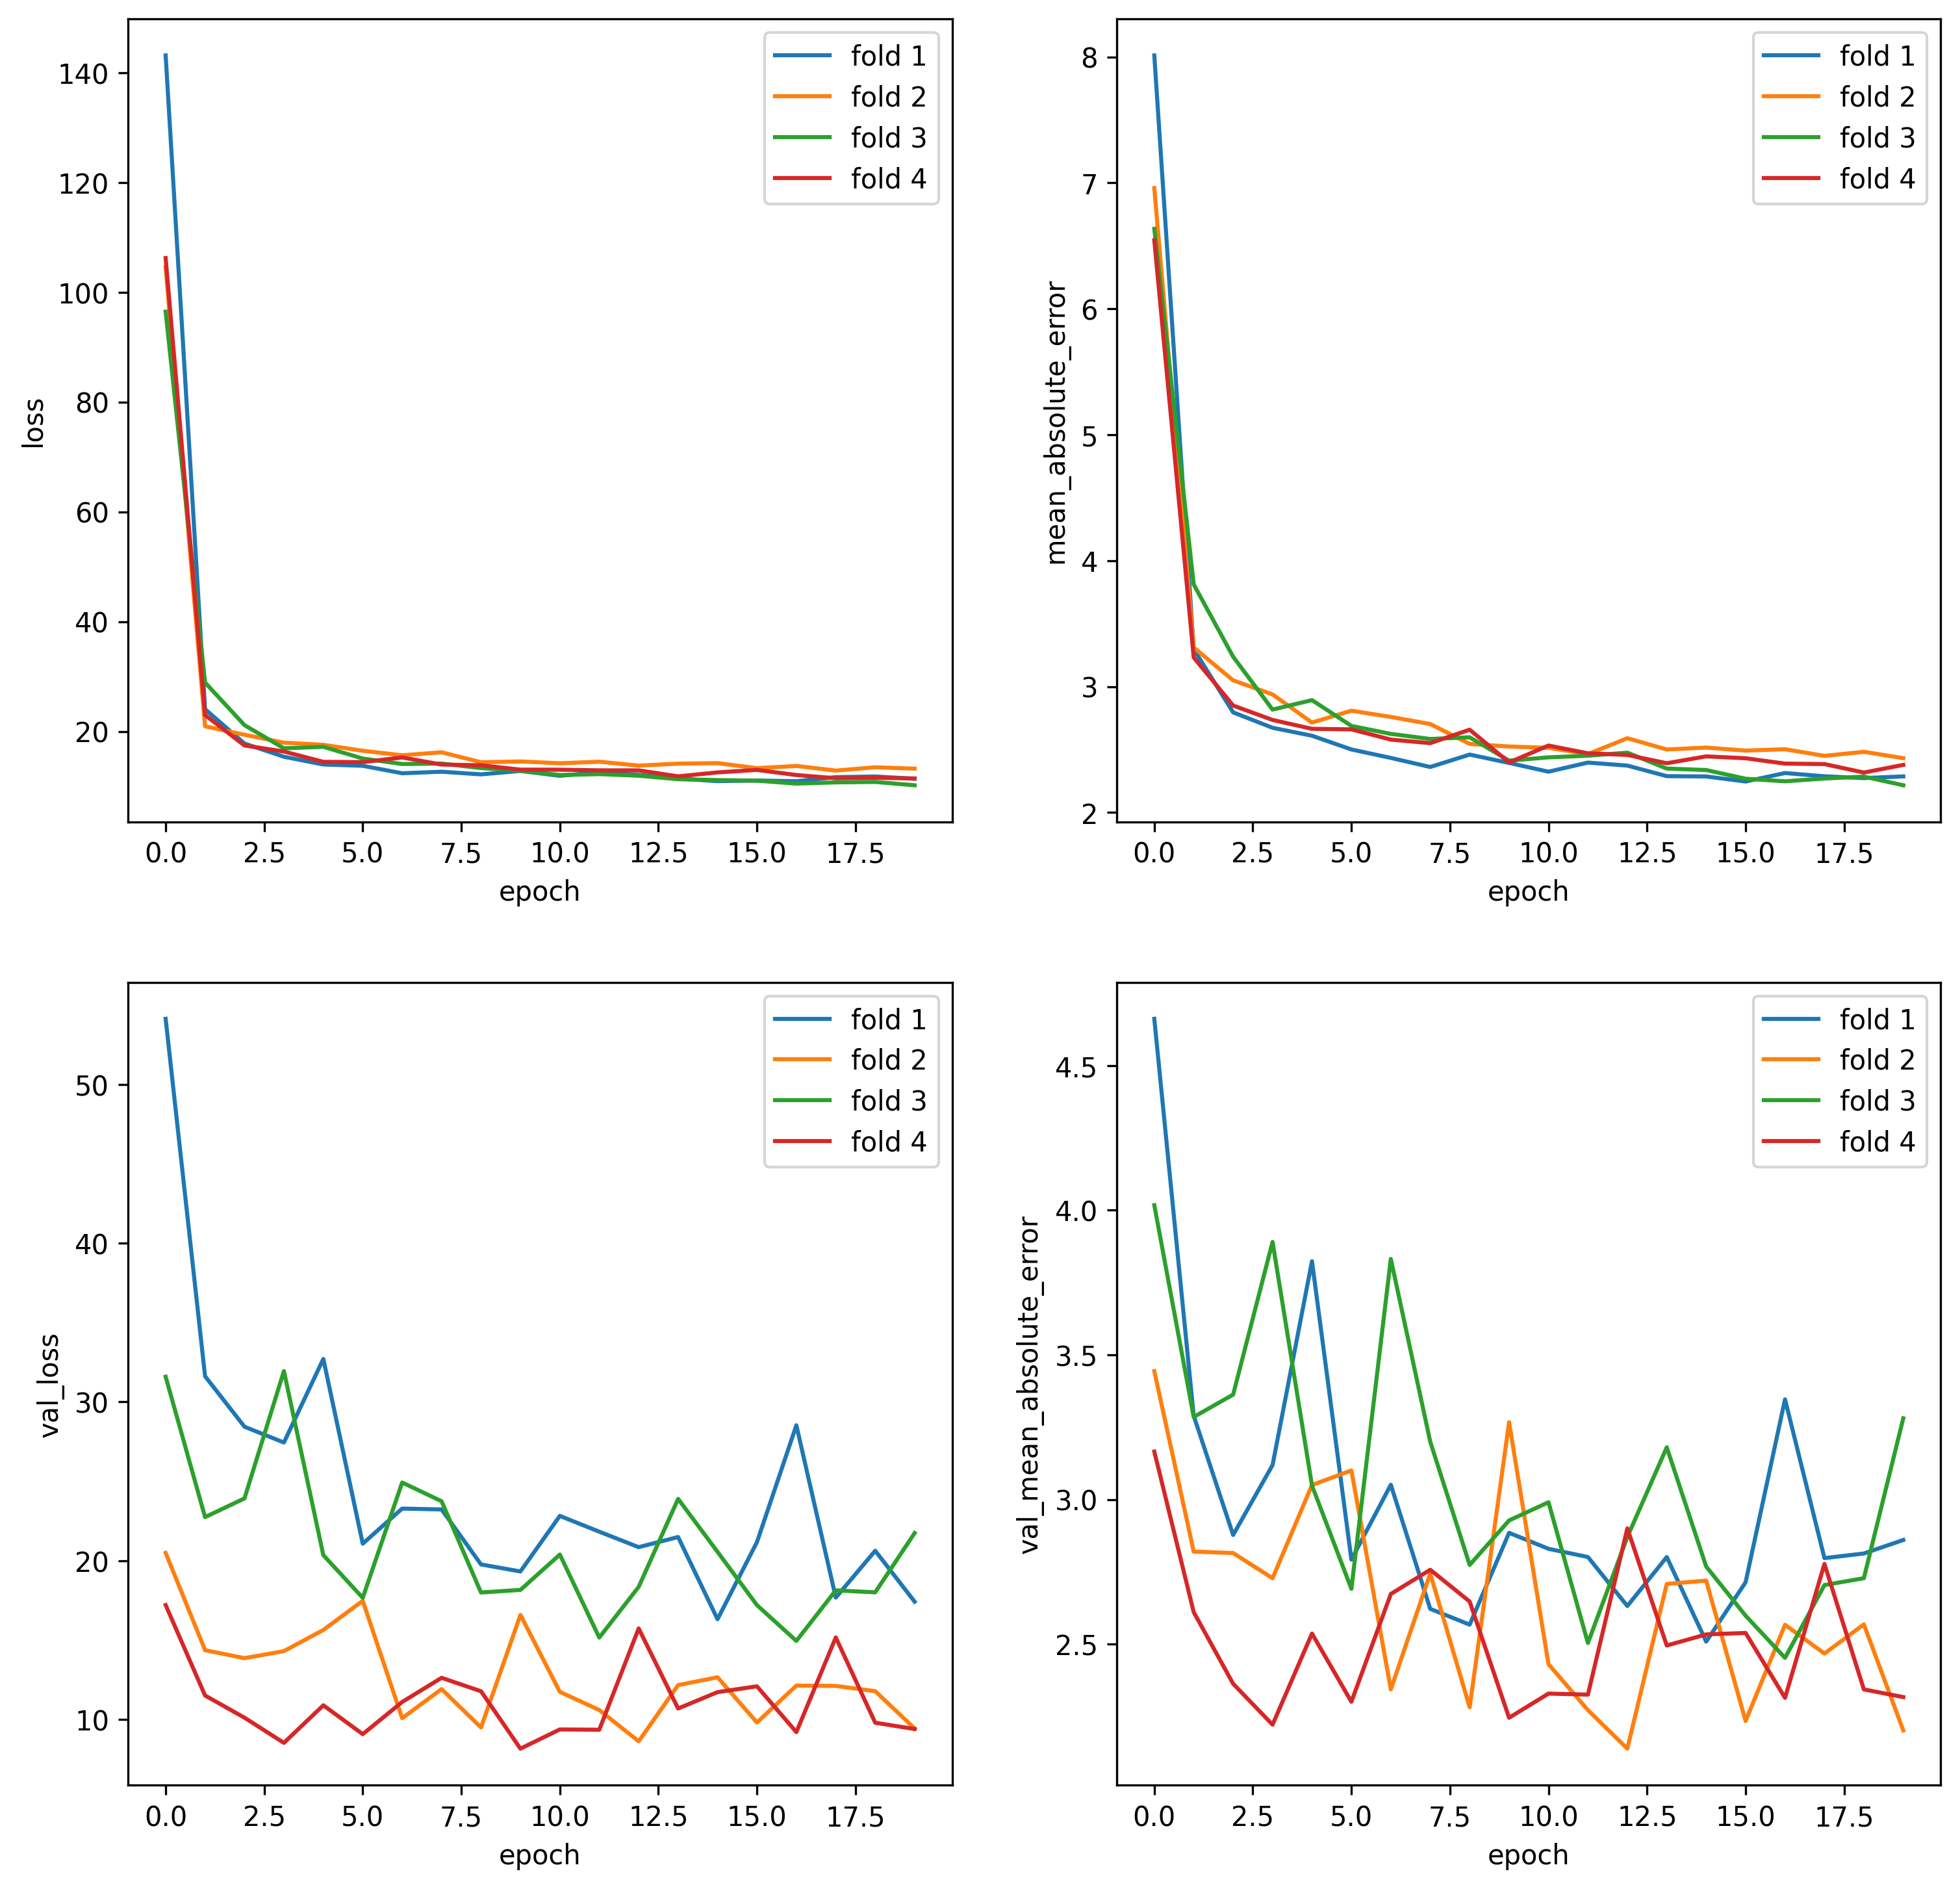

In [17]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=[12, 12], dpi=300)
axes = axes.ravel()

for i in range(4):
    sns.lineplot(x=range(20), y=histories[i].history['loss'], label=f'fold {i + 1}', ax=axes[0])
for i in range(4):
    sns.lineplot(x=range(20), y=histories[i].history['mean_absolute_error'], label=f'fold {i + 1}', ax=axes[1])
for i in range(4):
    sns.lineplot(x=range(20), y=histories[i].history['val_loss'], label=f'fold {i + 1}', ax=axes[2])
for i in range(4):
    sns.lineplot(x=range(20), y=histories[i].history['val_mean_absolute_error'], label=f'fold {i + 1}', ax=axes[3])

for i in range(4):
    axes[i].set_xlabel('epoch')

axes[0].set_ylabel('loss')
axes[1].set_ylabel('mean_absolute_error')
axes[2].set_ylabel('val_loss')
axes[3].set_ylabel('val_mean_absolute_error')

plt.show()